In [1]:
import os
import joblib
import logging
import pandas as pd
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

c:\Users\franc\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Function to predict sentences emotions

In [2]:
def predict_emotion(text, model_path, tokenizer_path, label_encoder_path):

    # Suppress informational messages from Transformers and TensorFlow
    logging.getLogger("transformers").setLevel(logging.ERROR)
    tf.get_logger().setLevel(logging.ERROR)

    # Load the model and tokenizer
    model = TFAutoModelForSequenceClassification.from_pretrained(model_path, from_pt=False)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    # Emotion dictionary
    emotion_dict = {
        0: 'anger',
        1: 'disgust',
        2: 'fear',
        3: 'happiness',
        4: 'sadness',
        5: 'surprise'
    }

    # Tokenize the input text and convert to tensors
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=512)

    # Predict
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])

    # Process the prediction
    predictions = tf.nn.softmax(outputs.logits, axis=-1)
    predicted_label_idx = tf.argmax(predictions, axis=-1).numpy()[0]

    # Map the predicted index to the corresponding emotion
    predicted_emotion = emotion_dict[predicted_label_idx]

    return predicted_emotion

In [3]:
# Loading the model
model_path = "models/Roberta_V3-final/model"
tokenizer_path = "models/Roberta_V3-final/tokenizer"
label_encoder_path = "models/Roberta_V3-final/label_encoder.joblib"

## Loading the dataframe with human labelled emotions

In [4]:
df = pd.read_csv('fragment_emotions.csv')
df

,Episode name,Fragment Number,Emotion_1,Emotion_2,Emotion_3,Emotion_4,Emotion_5,Emotion_6,Emotion_7,Emotion_8
0,1,2,happiness,surprise,surprise,no emotion,no emotion,no emotion,no emotion,no emotion
1,1,16,happiness,no emotion,no emotion,no emotion,no emotion,no emotion,no emotion,no emotion
2,1,18,disgust,no emotion,no emotion,no emotion,no emotion,no emotion,no emotion,no emotion
3,1,20,happiness,sadness,no emotion,no emotion,no emotion,no emotion,no emotion,no emotion
4,1,22,happiness,no emotion,no emotion,no emotion,no emotion,no emotion,no emotion,no emotion
...,...,...,...,...,...,...,...,...,...,...
437,17,14,surprise,sadness,no emotion,no emotion,no emotion,no emotion,no emotion,no emotion
438,17,15,no emotion,happiness,happiness,surprise,no emotion,no emotion,no emotion,no emotion
439,17,16,anger,happiness,surprise,sadness,no emotion,no emotion,no emotion,no emotion
440,17,17,happiness,happiness,sadness,no emotion,no emotion,no emotion,no emotion,no emotion


## Function to assess the model accuracy of the emotion prediction on all the available fragments

In [5]:
import pandas as pd
import os

def find_and_predict_emotion_for_episodes(start_episode, end_episode=None):
    if end_episode is None:
        end_episode = start_episode
        print(f"Processing episode {start_episode}")
    else:
        print(f"Processing episodes {start_episode} to {end_episode}...")

    total_fragments = 0
    correct_predictions = 0
    predictions_data = []

    for episode_num in range(start_episode, end_episode + 1):
        episode_mask = df['Episode name'] == episode_num
        for fragment_num in df[episode_mask]['Fragment Number'].unique():
            transcription_path = f"transcriptions_per_episode/ep_{episode_num}/ER22_ep{episode_num}_fra_{fragment_num}.txt"
            

            if os.path.exists(transcription_path):
                total_fragments += 1
                with open(transcription_path, 'r', encoding='utf-8') as file:  # Specify encoding here
                    transcription_text = file.read()


                predicted_emotion = predict_emotion(transcription_text, model_path, tokenizer_path, label_encoder_path)
                
                filtered_df = df[(df['Episode name'] == episode_num) & (df['Fragment Number'] == fragment_num)]
                emotion_columns = [col for col in df.columns if 'Emotion_' in col]
                row_emotions = set(filtered_df.iloc[0][emotion_columns].values) - {'no emotion'}
                
                correct_prediction = predicted_emotion in row_emotions
                if correct_prediction:
                    correct_predictions += 1
                
                predictions_data.append({
                    'Episode': episode_num,
                    'Fragment': fragment_num,
                    'Predicted Emotion': predicted_emotion,
                    'Actual Emotions': list(row_emotions),
                    'Correct': correct_prediction
                })

    if total_fragments > 0:
        accuracy = correct_predictions / total_fragments
        print(f"\nOut of {total_fragments} predicted fragments, the model correctly identified one of the fragment's emotions {correct_predictions} times, giving an accuracy of {accuracy:.2f}.")
    else:
        print("\nNo fragments were found or processed. Please check the episode range and data.")
    
    predictions_df = pd.DataFrame(predictions_data)
    return predictions_df


In [13]:
# Example usage
start_episode = 1
end_episode = 17
predictions_df = find_and_predict_emotion_for_episodes(start_episode, end_episode)


Processing episodes 1 to 17...

Out of 442 predicted fragments, the model correctly identified one of the fragment's emotions 169 times, giving an accuracy of 0.38.


As we can see our best model - which scored a 0.905 average F1 score in our Kaggle competition's public leaderboard - reached an accuracy of only 0.38 on the labelled fragments of the Expedite Robinson fragments. There are a number of reasons that justify this drop in performance:

- it's important to note that the training data of our model consisted of written sentences whereas the ER22 data was about **speech**

- Although the Whisper API has a good performance, the Expedite Robinson data was transcribed and translated, and there is also the fact that the human annotators also had a visual data for their annotations (the video of the fragment rather than the audio) so there could have been some loss of information throughout this process that causes the model to perform worse.
- the human labels don't exactly match our model's possible labels (they had either to be mapped for cases such as joyful or love to happiness or in the case of labels like hunger excluded all together because they don't make sense)
- our models were trained on a dataset where a single sentences has 1 emotion mapped to it whereas in the ER22 fragments, the model has to detect 1 emotions out of multiple sentences which might include more than 1 emotion.

This analysis can be useful to understand what should be fine-tuned and changed in the future:

- Train multiclass emotion classification models
- Train new models on more labels that better represent the data/labels you want to extract from the fragments
- Changing the whisper API model from base to Large, the processing speed would decrease immensely but the accuracy might improve


In [40]:
predictions_df.to_csv('ER_data_errors.csv', index=False)

In [2]:
predictions_df = pd.read_csv('ER_data_errors.csv')

In [35]:
predictions_df.tail(5)

,Episode,Fragment,Predicted Emotion,Actual Emotions,Correct
437,17,14,sadness,"[sadness, surprise]",True
438,17,15,happiness,"[happiness, surprise]",True
439,17,16,fear,"[sadness, anger, happiness, surprise]",False
440,17,17,happiness,"[sadness, happiness]",True
441,17,18,fear,"[happiness, surprise]",False


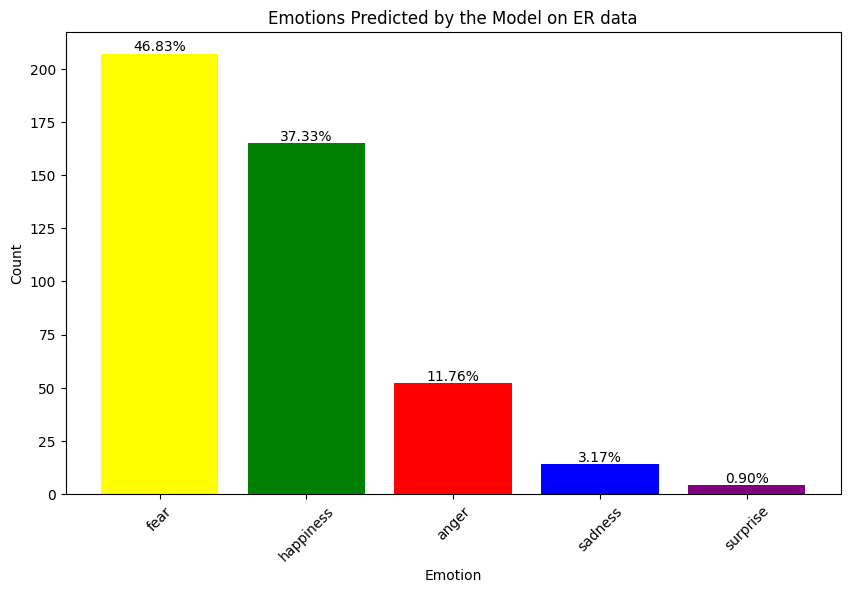

In [29]:
import matplotlib.pyplot as plt

# Count the occurrences of each predicted emotion
emotion_counts = predictions_df['Predicted Emotion'].value_counts()

# Calculate the percentage of each predicted emotion
total_count = len(predictions_df)
emotion_percentages = emotion_counts / total_count * 100

# Plot the emotions
plt.figure(figsize=(10, 6))
bars = plt.bar(emotion_counts.index, emotion_counts.values, color=['yellow', 'green', 'red', 'blue', 'purple'])

# Add percentage labels on top of the bars. Use emotion_percentages for the text.
for bar, percentage in zip(bars, emotion_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.2f}%', ha='center', va='bottom')

plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotions Predicted by the Model on ER data')
plt.xticks(rotation=45)
plt.show()


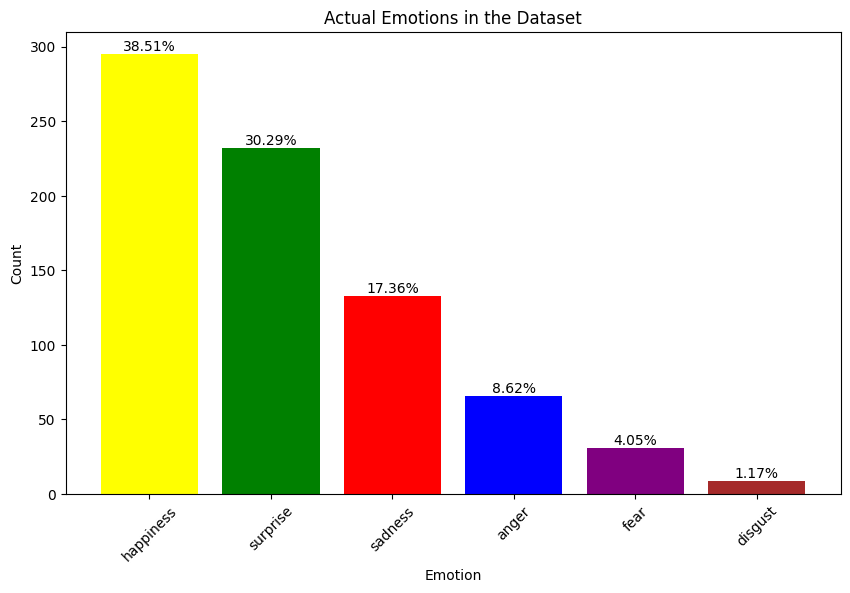

In [34]:


# Unwrap the 'Actual Emotions' column into a flat list
all_actual_emotions = sum(predictions_df['Actual Emotions'], [])

# Count occurrences of each actual emotion
actual_emotion_counts = pd.Series(all_actual_emotions).value_counts()

# Calculate the percentage of each actual emotion
total_actual_emotions = len(all_actual_emotions)
actual_emotion_percentages = actual_emotion_counts / total_actual_emotions * 100

# Plot the actual emotions
plt.figure(figsize=(10, 6))
bars = plt.bar(actual_emotion_counts.index, actual_emotion_counts.values, color=['yellow', 'green', 'red', 'blue', 'purple', 'brown'])

# Add percentage labels on top of the bars. Use actual_emotion_percentages for the text.
for bar, percentage in zip(bars, actual_emotion_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.2f}%', ha='center', va='bottom')

plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Actual Emotions in the Dataset')
plt.xticks(rotation=45)
plt.show()


## Precision, Recall and F1 trade-off in the context of the client problem

**Precision in Context:** 

For Banijay, a high precision would mean that when your pipeline classifies an audio segment as expressing a certain emotion, it is very likely correct. This is particularly important in scenarios where the misclassification of content could lead to inappropriate categorization of shows or segments, potentially leading to problems such as adult content (portaying emotions of violence and anger for example) being misclassified as appropriate for young audiences.

**Recall in Context:** 

For Banijay, high recall would mean that your model is capable of identifying most or all audio segments that express a particular emotion. This is crucial for ensuring that the emotional content of shows is fully understood and categorized, and can be specifically useful when attempting to detect a certain emotion that is more highly correlated with higher audiences.

**F1 score and accuracy in Context:**

These metrics can provide a good balance between precision and recall. If they are high they indicate a good overall performance of the pipeline. However, they can be misleading in cases where there is an imbalanced dataset, which appears to be the case of Expeditie Robinson as can be seen in the graph above where the majority of the labels is referring to the happiness and surprise labels. 

---

**Summary:** Ideally all of these metrics would be quite high and they would indicate an amazing performance of the pipeline.Moving on with the project we will implement strategies to increase all of them but in the end there needs to be a discussion with the client, Banijay, to understand what is more important to them.